## E1 - Label Noise

I implemented 2LR Plugin-Approach (Bobs Paper) and analyse how label noise affects the tradeoff between Fairness and Performance

Fairness Metric: Mean Distance
Performance Metric: Balanced Error

In [2]:

from random import seed, shuffle
from tqdm import tqdm
import sys
sys.path.insert(1, '/home/ptr@itd.local/code/fairness_triangle/tools') # so i can import tools
from gen_synth_data import *
from plot_helper import *
from corrupt_labels import *
from calc_metrics import *
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
#Configuration to make plots nicer
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Data Generation and Regression Fitting

In [3]:
np.linspace(-1,2,21)

array([-1.  , -0.85, -0.7 , -0.55, -0.4 , -0.25, -0.1 ,  0.05,  0.2 ,
        0.35,  0.5 ,  0.65,  0.8 ,  0.95,  1.1 ,  1.25,  1.4 ,  1.55,
        1.7 ,  1.85,  2.  ])

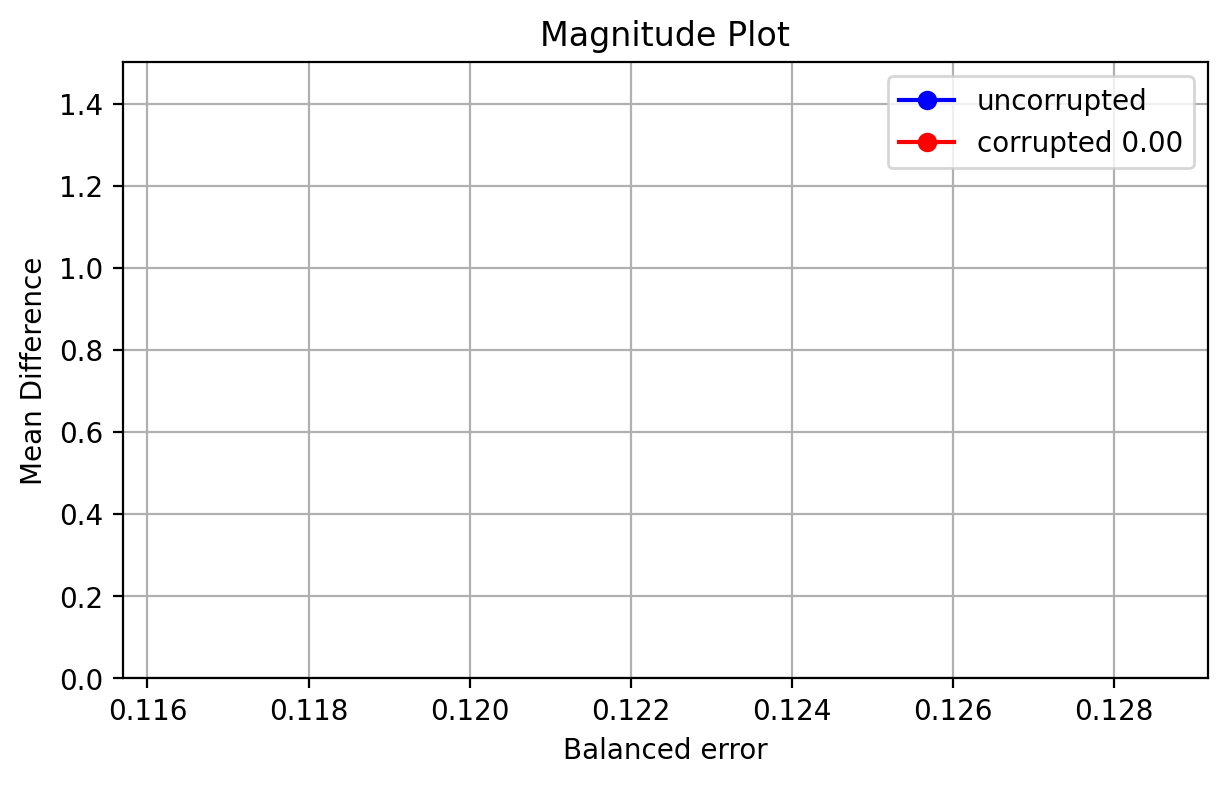

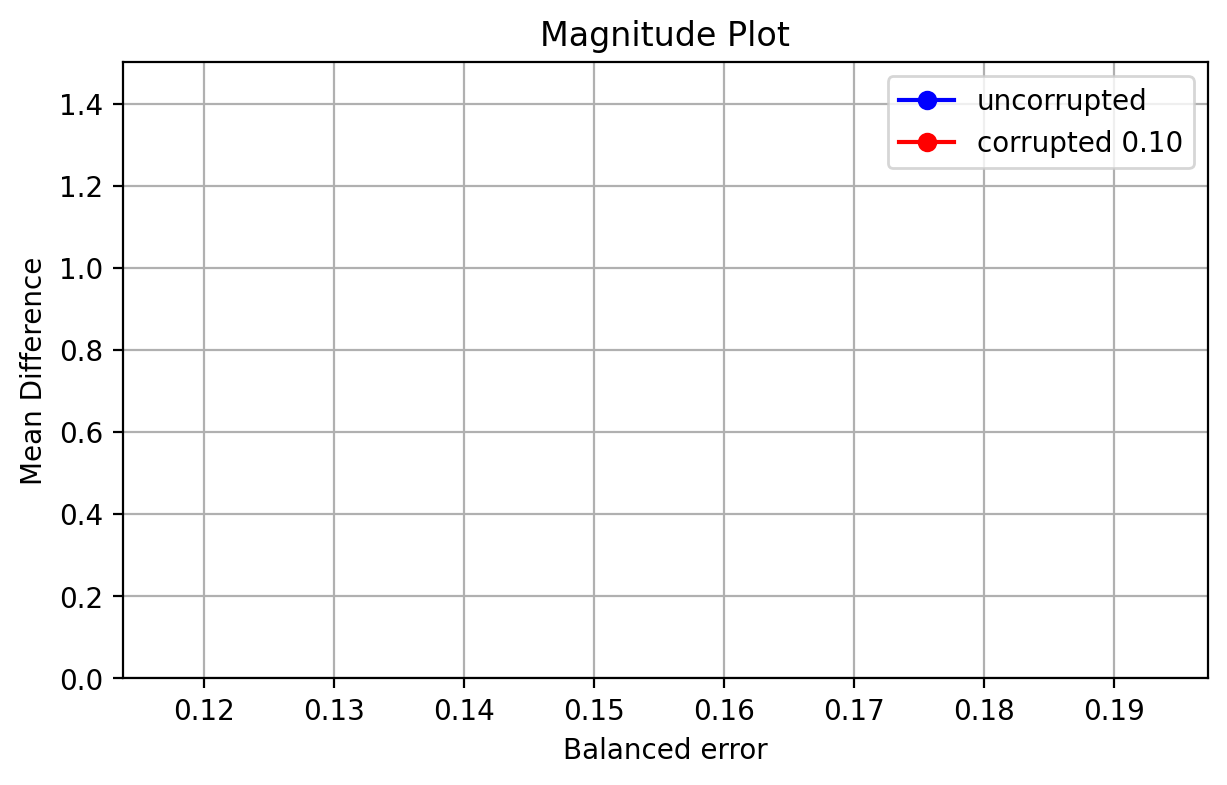

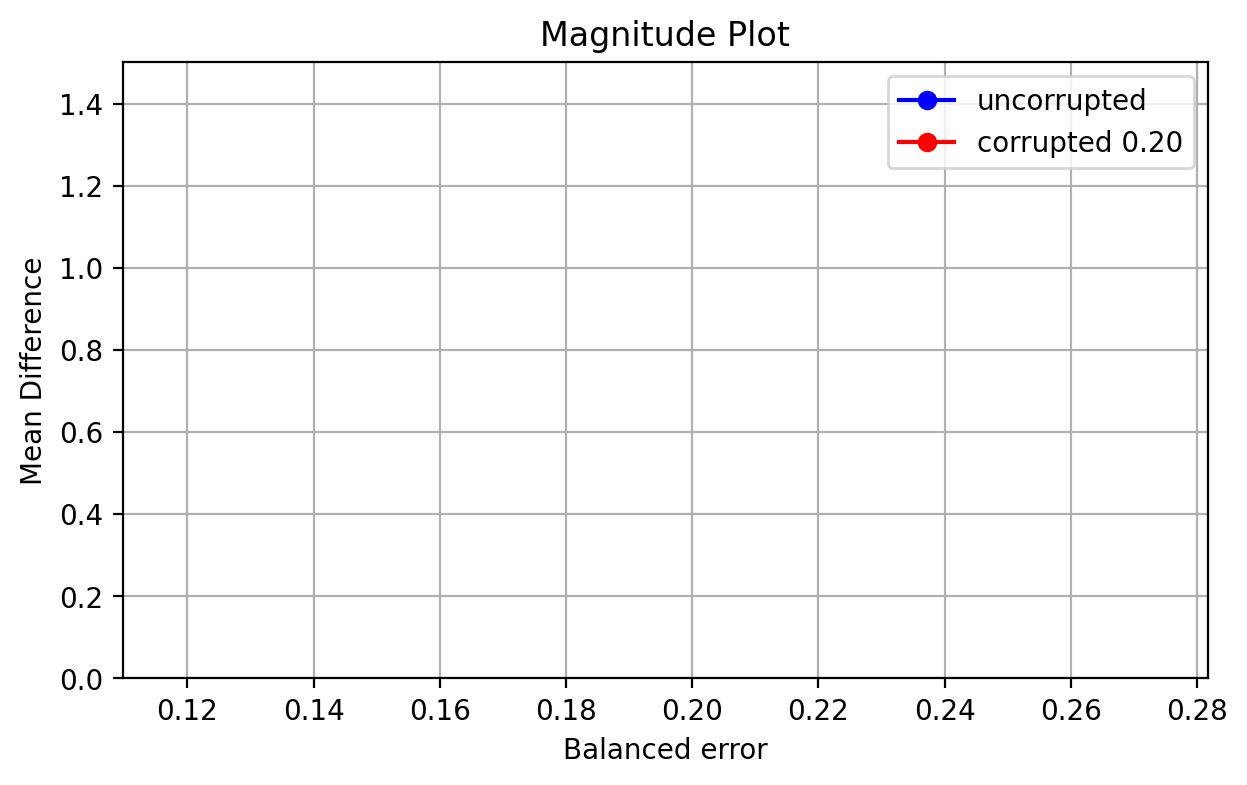

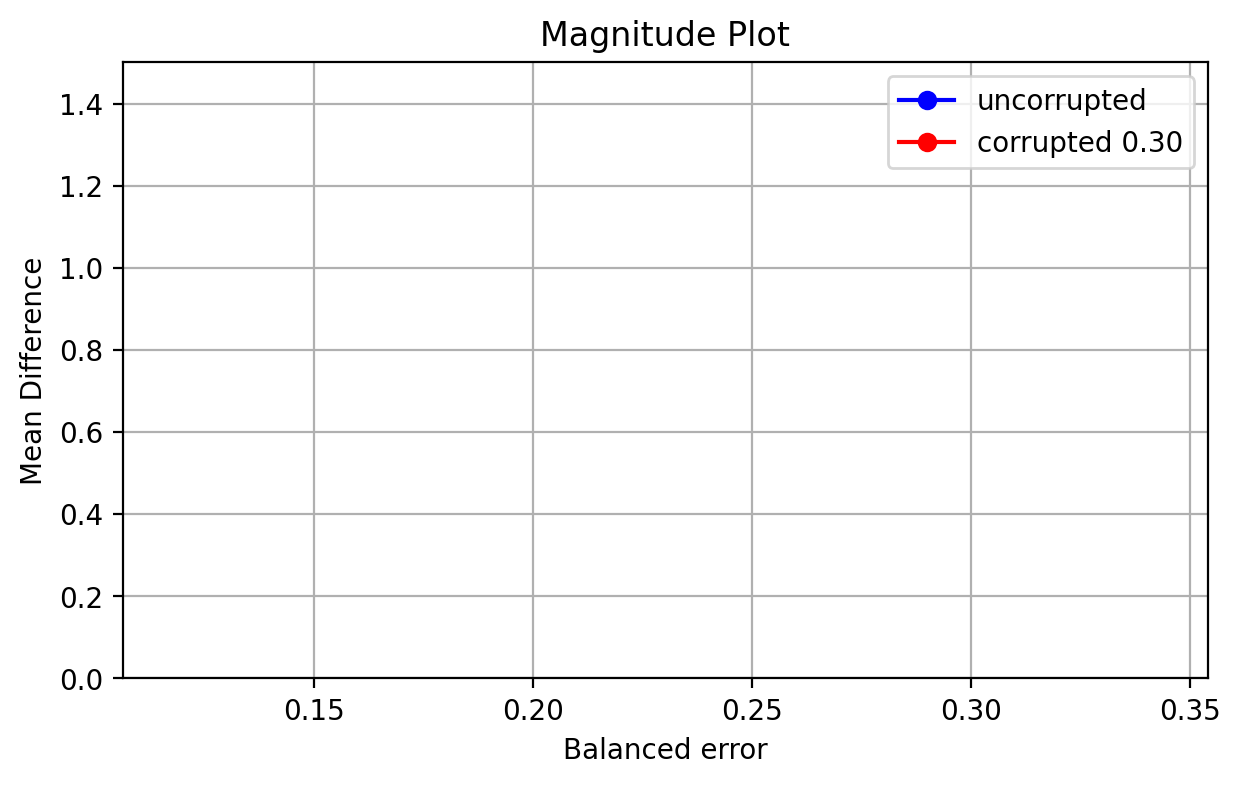

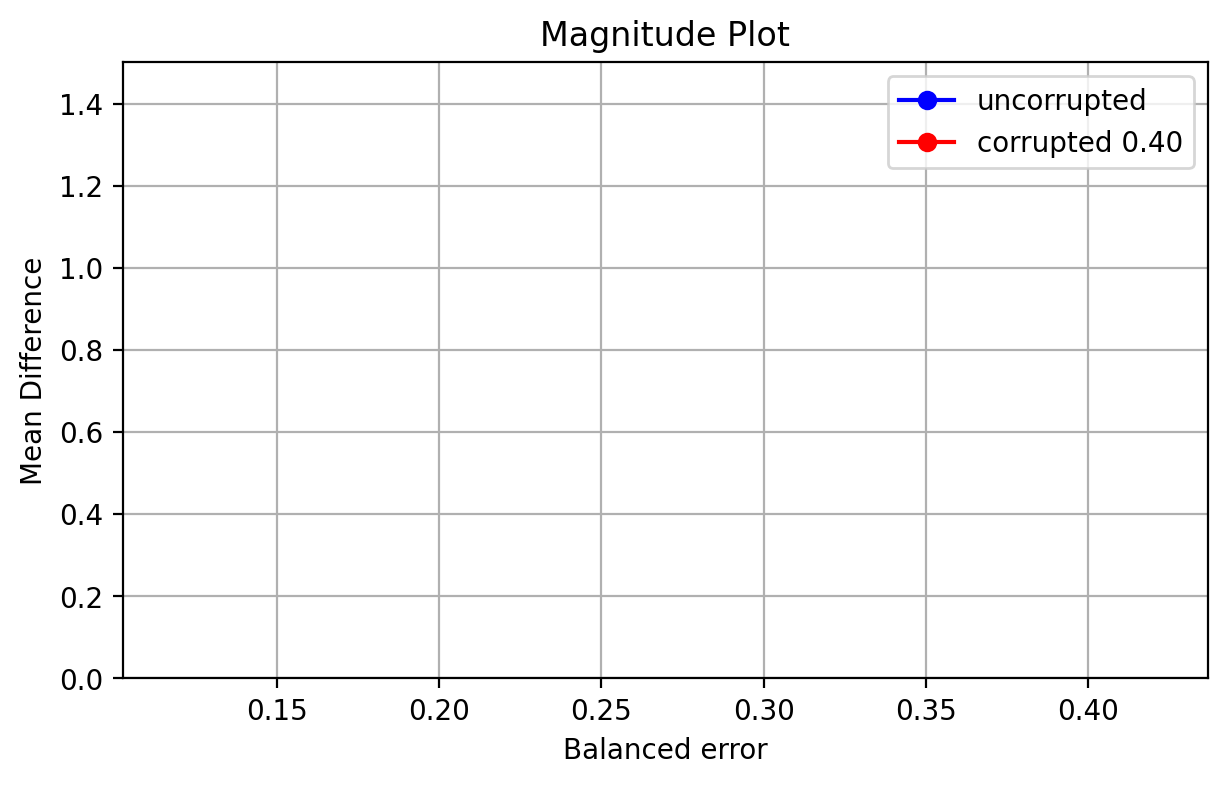

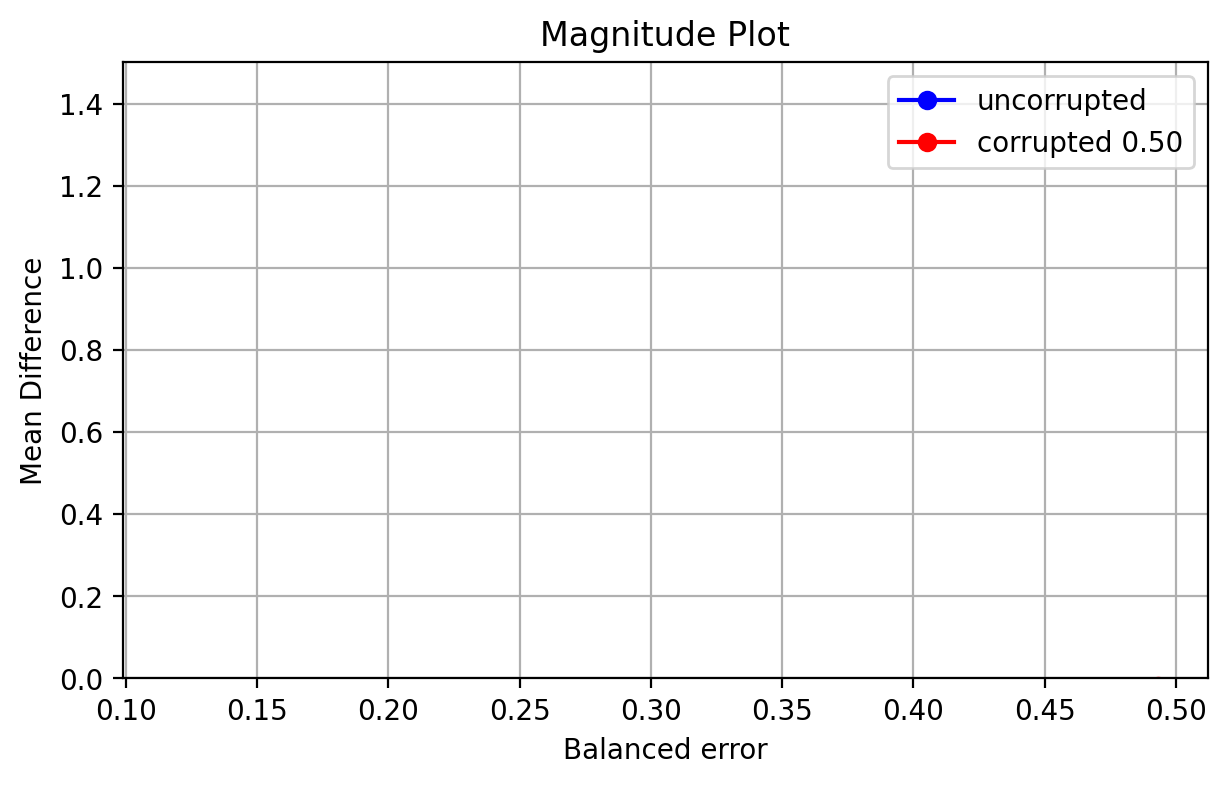

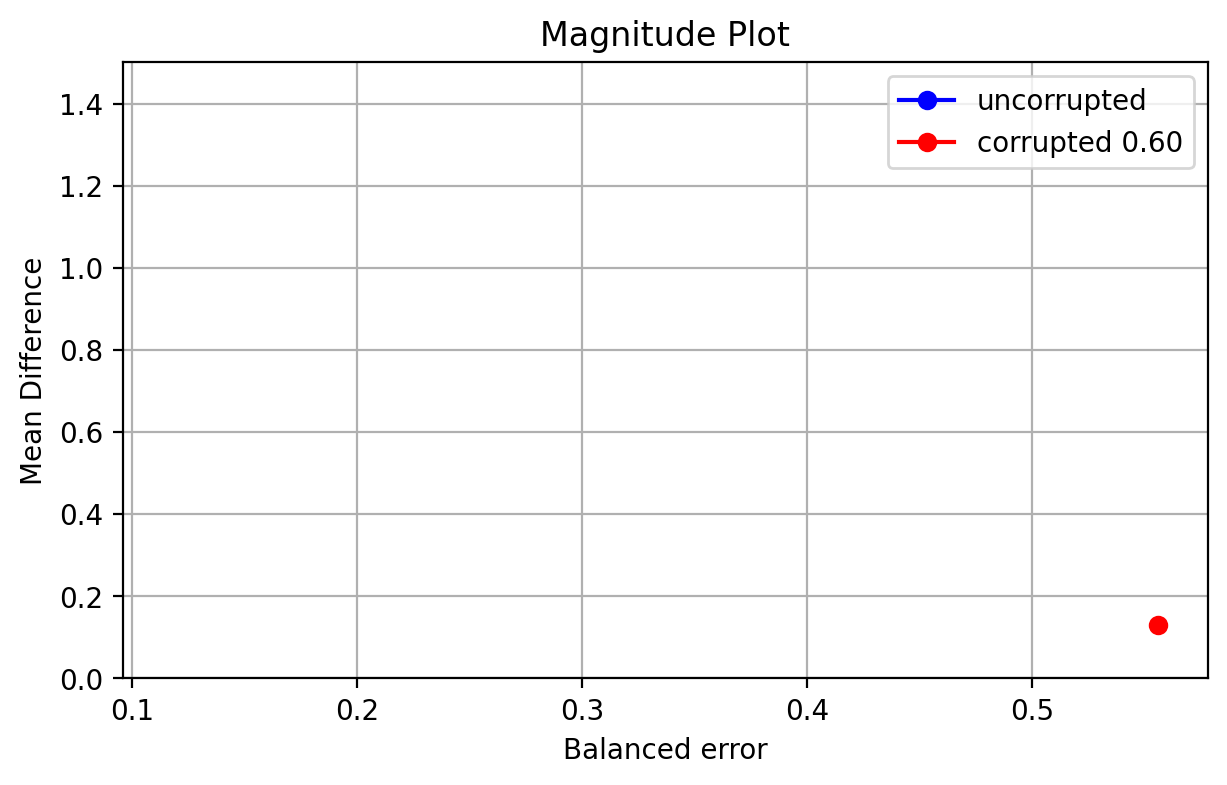

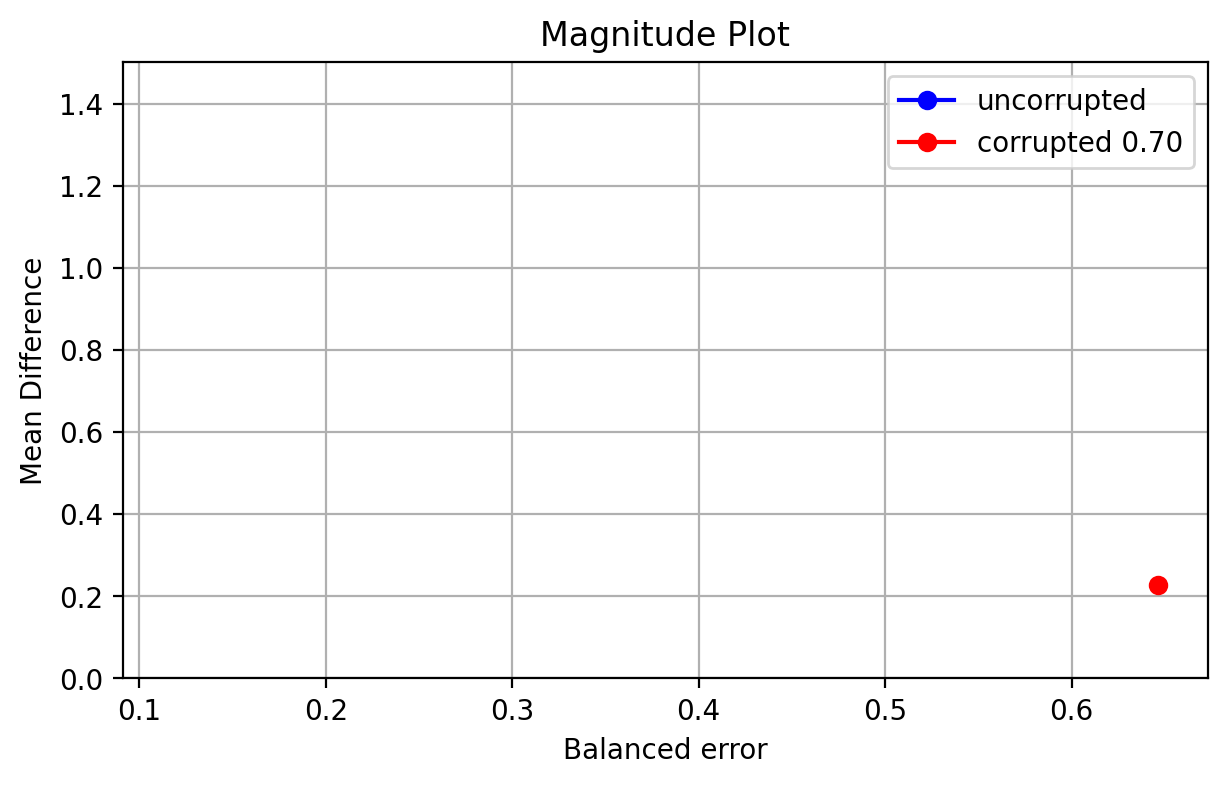

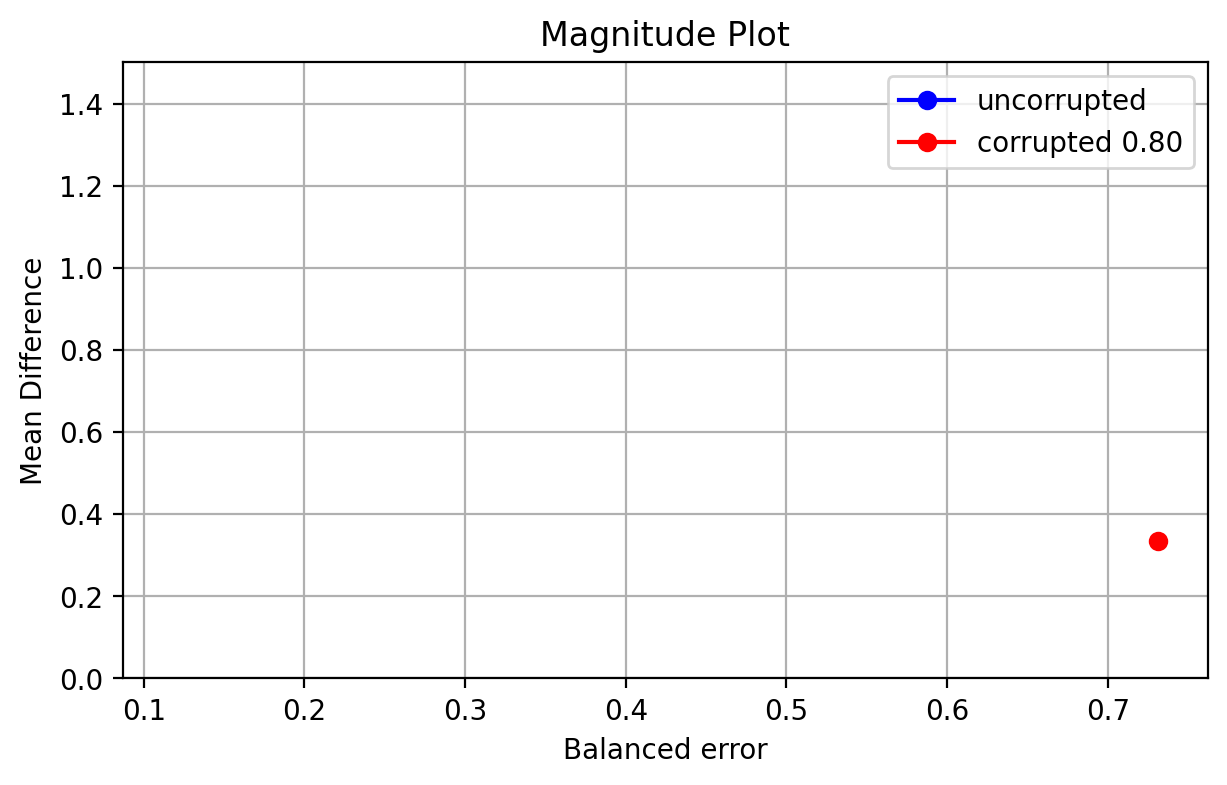

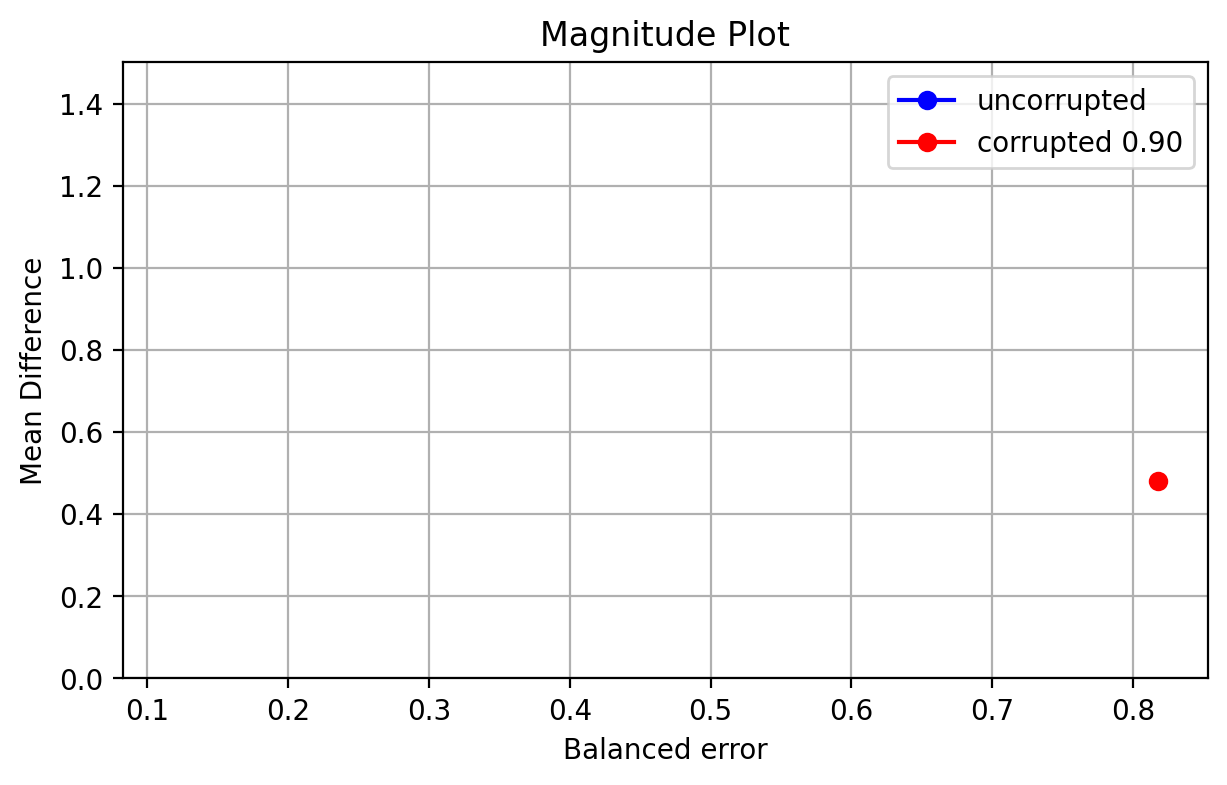

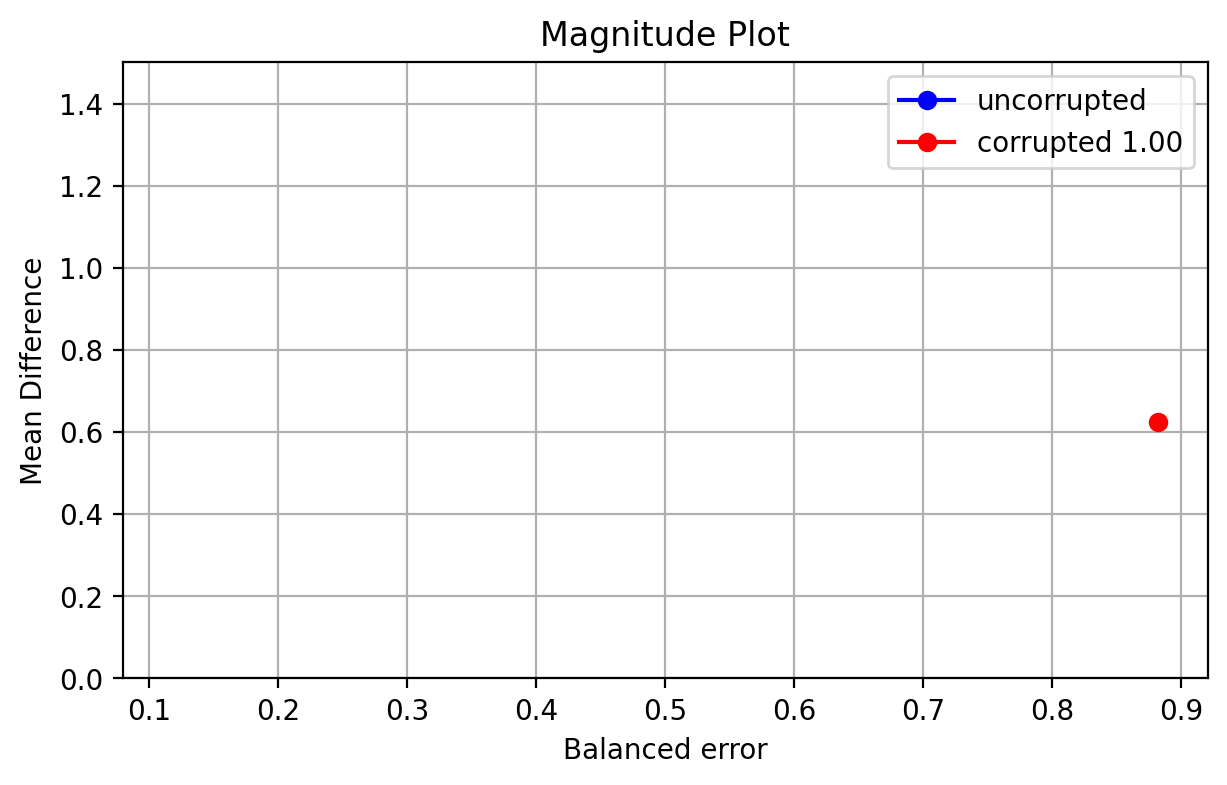

In [5]:
np.random.seed(0)  # Set seed for reproducibility
flip_prob = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]  # Probability of flipping label (target variable)
disc_factor = 0.5 #How similar is the sensitive attribute the the input X
lmd = -0.5  #How important is fairness classification

for flip in flip_prob:
    X, Y, Y_sen = generate_synthetic_data(False, n_samples=2000, disc_factor=disc_factor)    #n_samples are per gaussian distributions, we have two hence total_n = 2*n_samples

    Y_corrupted = add_bin_noise(Y, flip)
    Y_sen_corrupted = add_bin_noise(Y_sen, flip)

    #Devide Set into training and test set
    split_index = int(0.7 * len(X))

    # Split the points into training and testing sets (80/20)
    X_train, X_test = X[:split_index], X[split_index:]
    Y_train, Y_test = Y[:split_index], Y[split_index:]
    Y_sen_train, Y_sen_test = Y_sen[:split_index], Y_sen[split_index:]
    Y_corr_train, Y_corr_test = Y_corrupted[:split_index], Y_corrupted[split_index:]
    Y_sen_corr_train, Y_sen_corr_test = Y_sen_corrupted[:split_index], Y_sen_corrupted[split_index:]

    p_reg, p_reg_cor, f_reg, f_reg_cor = LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression()
    p_reg.fit(X_train, Y_train)
    p_reg_cor.fit(X_train, Y_corr_train)
    f_reg.fit(X_train, Y_sen_train)
    f_reg_cor.fit(X_train, Y_sen_corr_train)

    BER_list = []
    MD_list = []
    DI_list = []

    BER_list_corr = []
    MD_list_corr = []
    DI_list_corr = []

    # Cost sensitivity of classes
    c, c_bar = 0.5, 0.5


    s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)
    # Apply step function H_a(z) with a = 0
    Y_pred = np.where(s > 0, 1, 0)

    BER = calc_BER(Y_pred, Y_test)
    MD = calc_MD(Y_pred, Y_sen_test, True)
    DI = calc_DI(Y_pred, Y_sen_test, True)
    BER_list.append(BER)
    MD_list.append(MD)
    DI_list.append(DI)

    s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)
    # Apply step function H_a(z) with a = 0
    Y_pred = np.where(s > 0, 1, 0)

    BER = calc_BER(Y_pred, Y_corr_test)
    MD = calc_MD(Y_pred, Y_sen_corr_test, False)
    DI = calc_DI(Y_pred, Y_sen_corr_test, False)

    BER_list_corr.append(BER)
    MD_list_corr.append(MD)
    DI_list_corr.append(DI)


    plt.figure(figsize=(7,4))
    plt.plot(BER_list[0],MD_list[0], marker='o', color='b', label='uncorrupted')
    plt.plot(BER_list_corr[0],MD_list_corr[0], marker='o', color='r', label=f'corrupted {flip:.2f}')


    # Add labels and title
    plt.xlabel("Balanced error")
    plt.ylabel("Mean Difference")
    plt.title("Magnitude Plot")
    plt.ylim(0,1.5)
    plt.legend()
    # Show grid
    plt.grid(True)
    plt.savefig(f"../img/E1_Label_Noise_for_Single_Points/Lambda_Effect_on_Corruption_lmd_{lmd:.4f}.png")

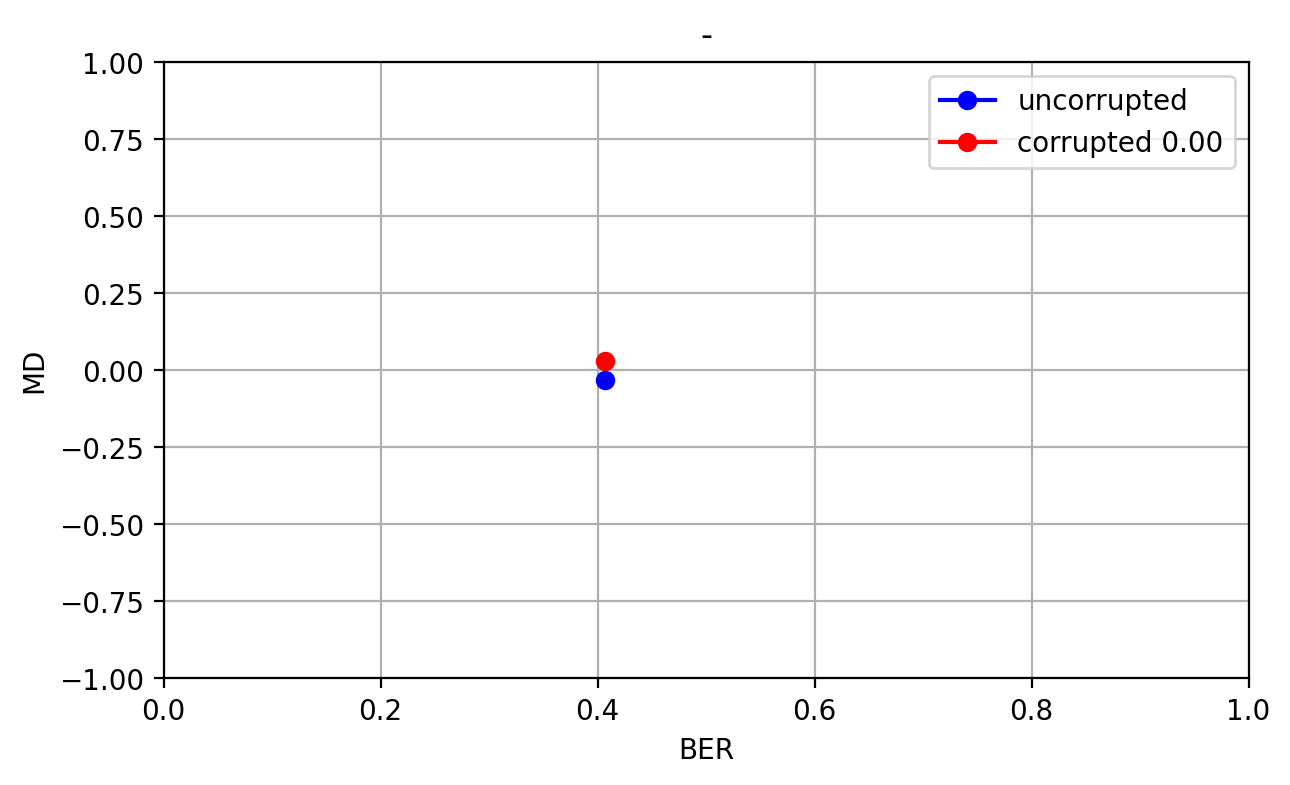

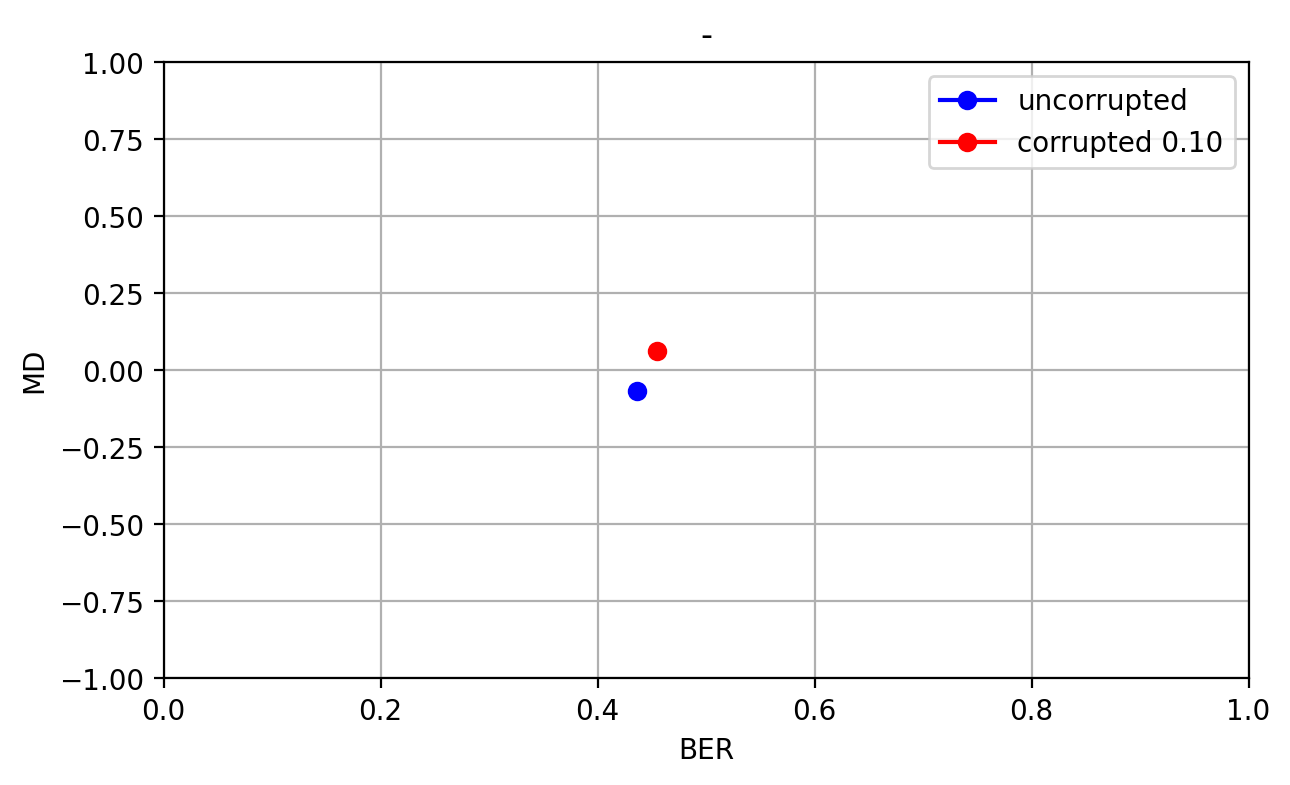

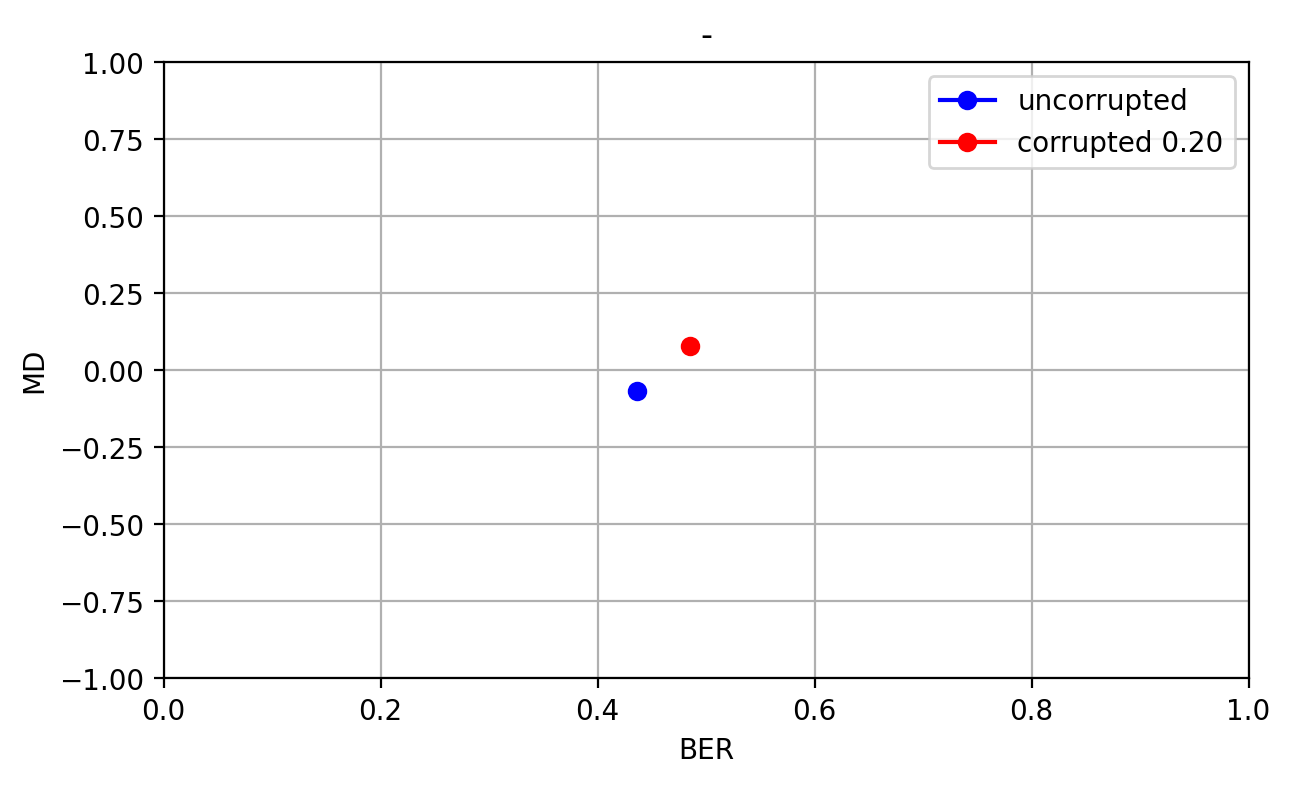

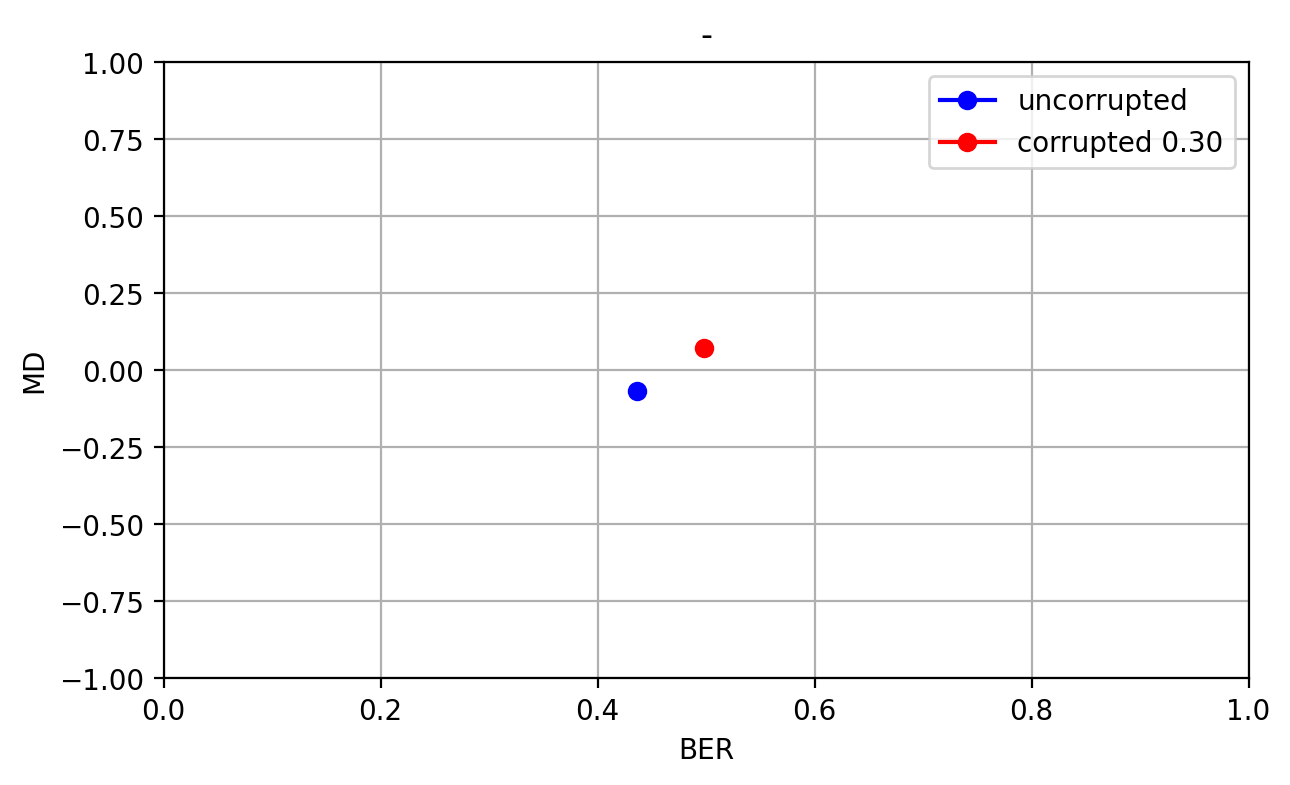

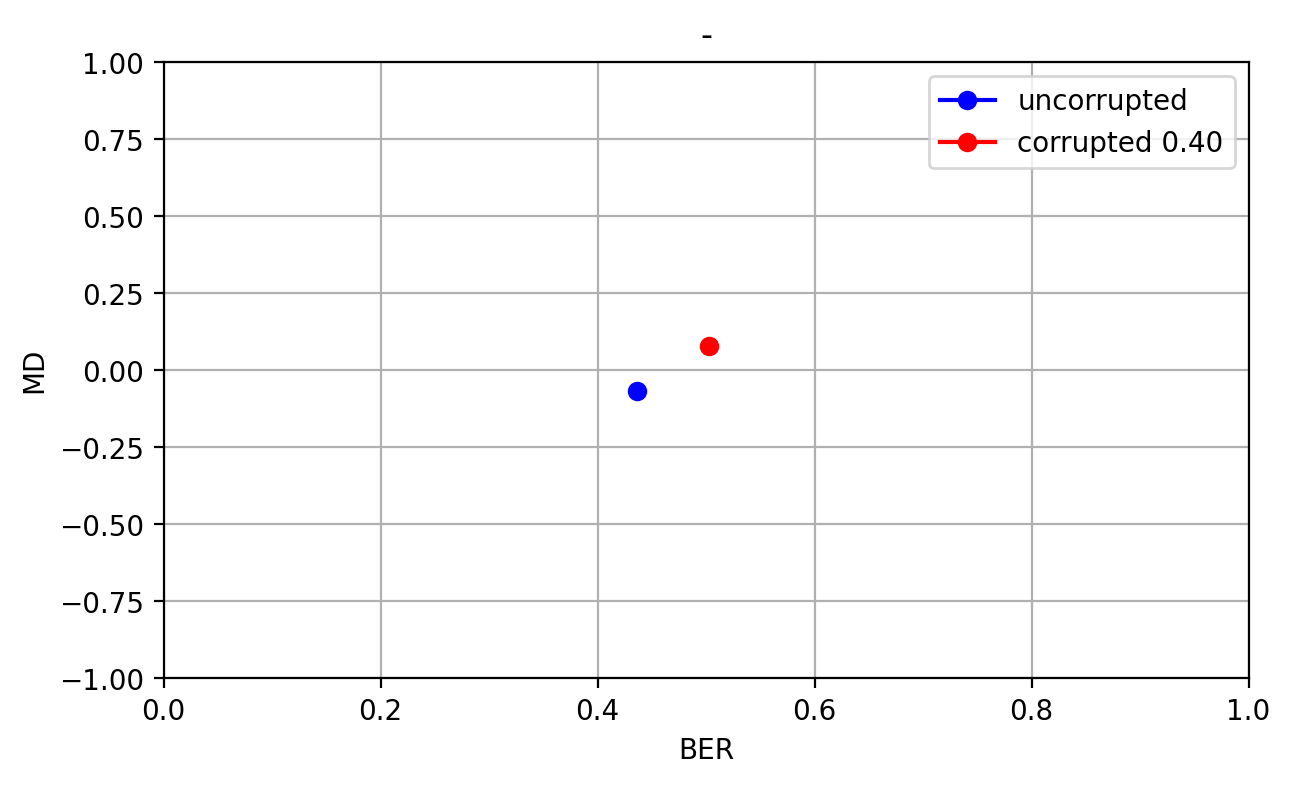

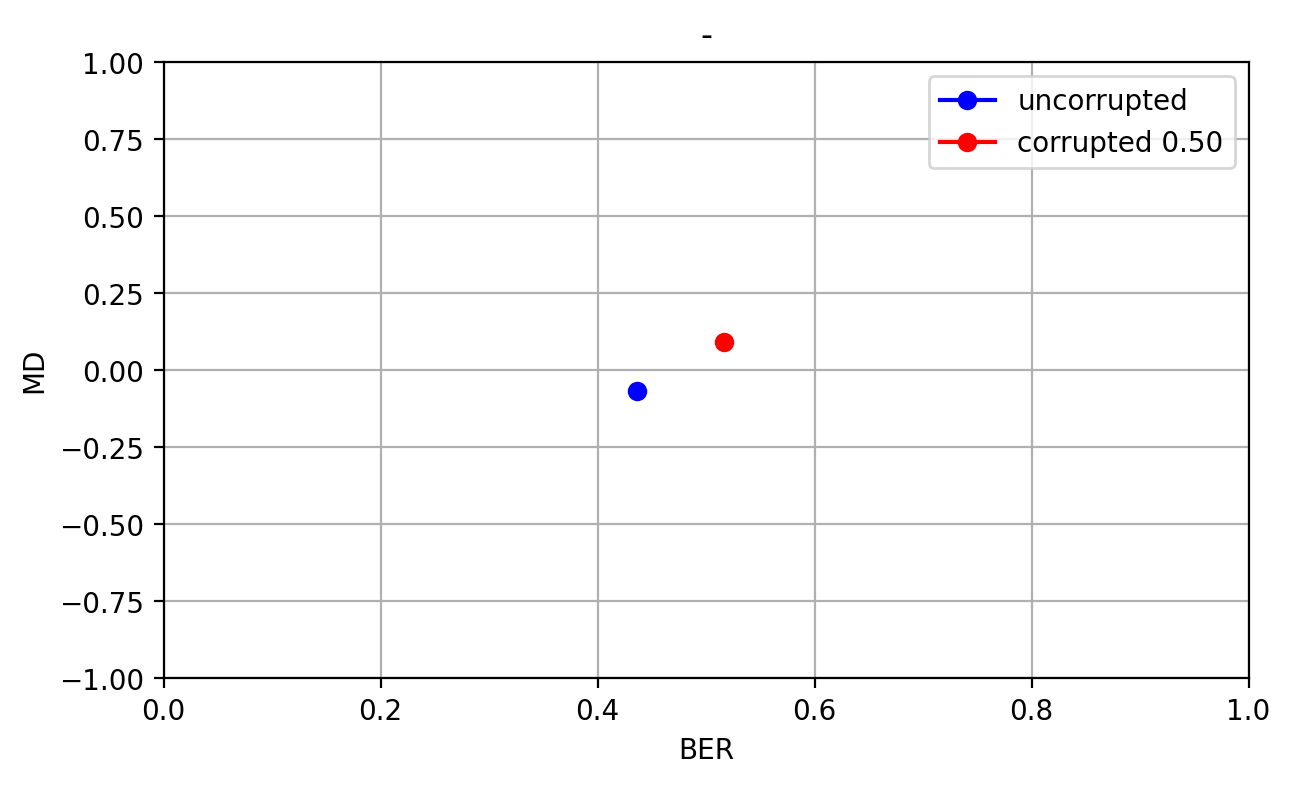

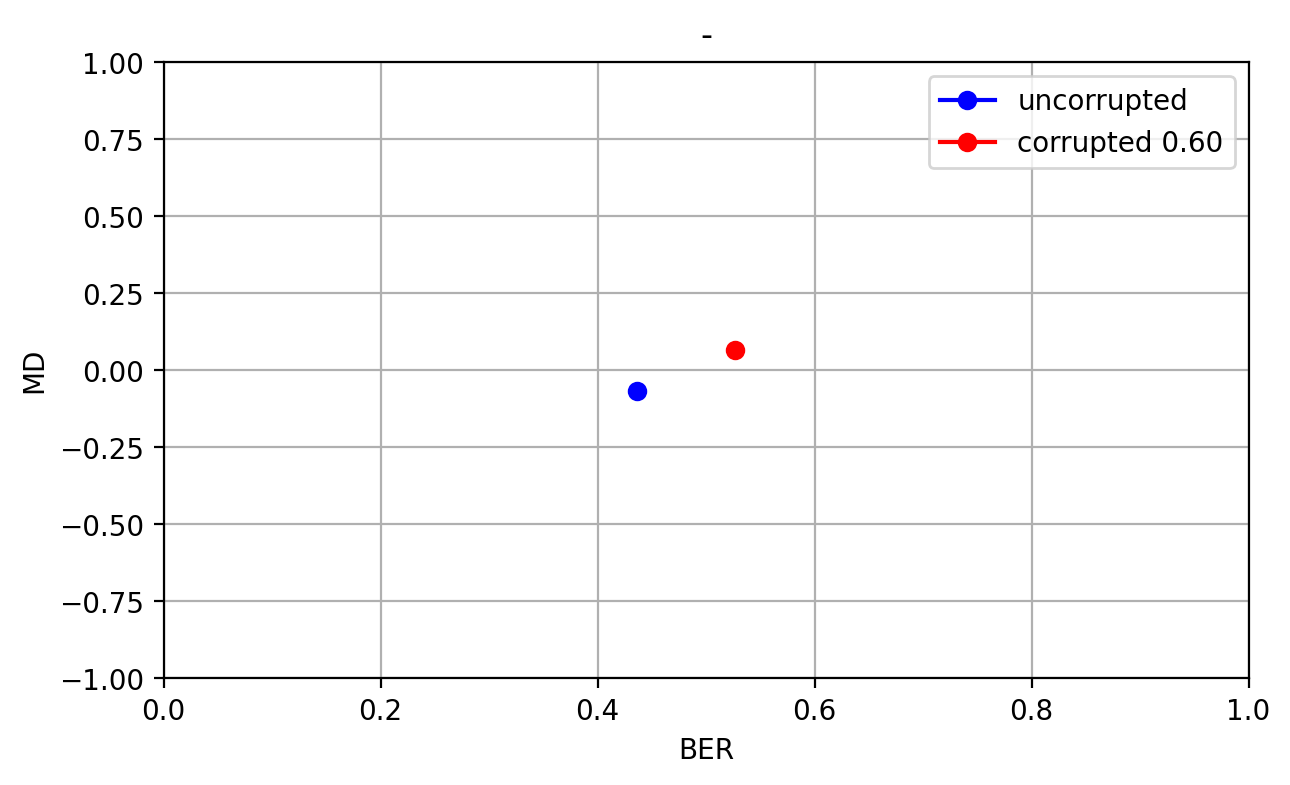

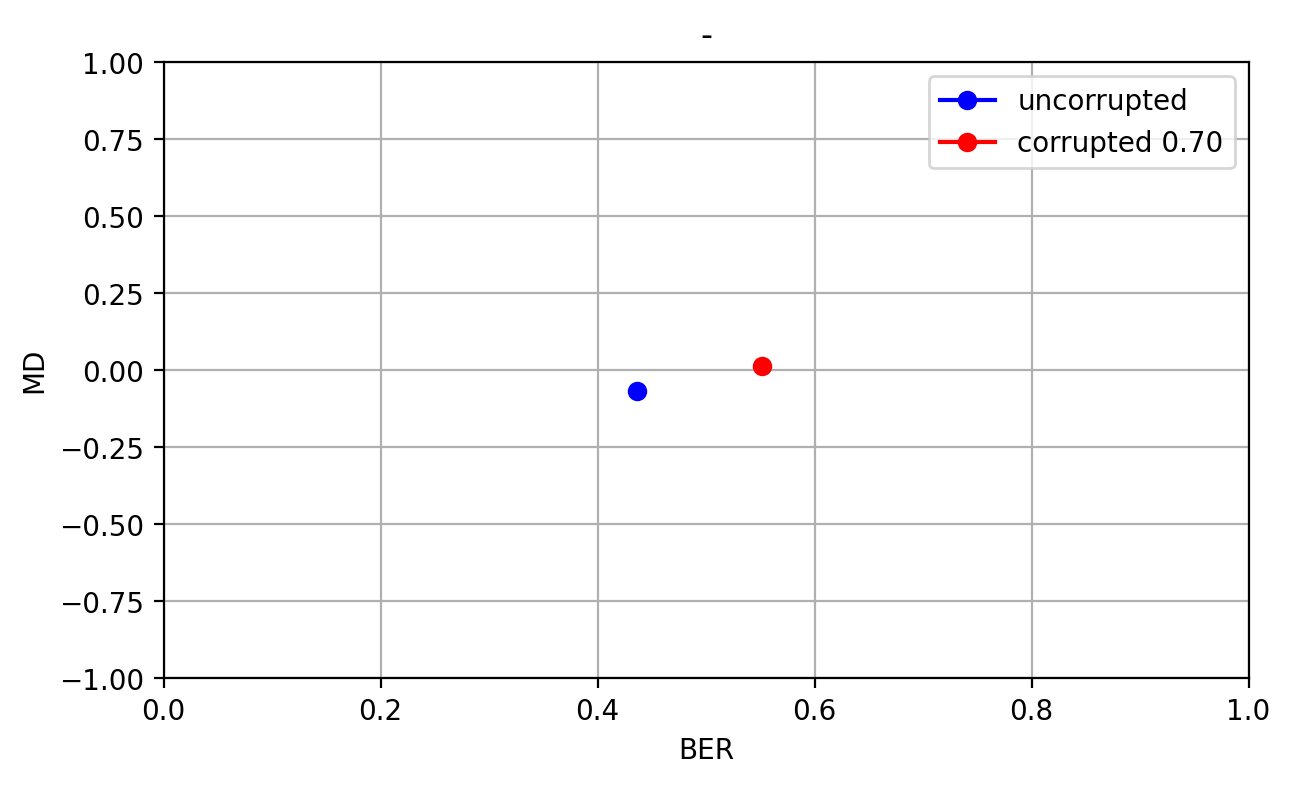

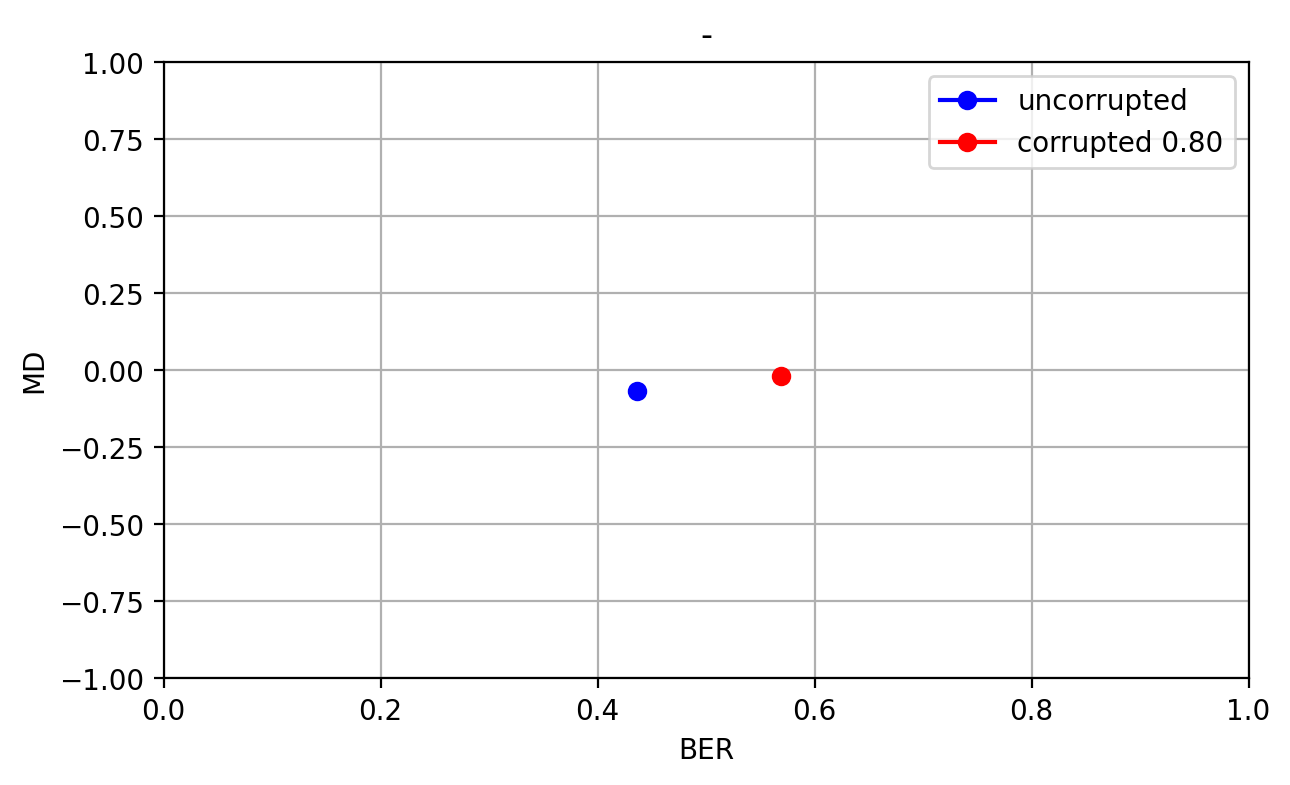

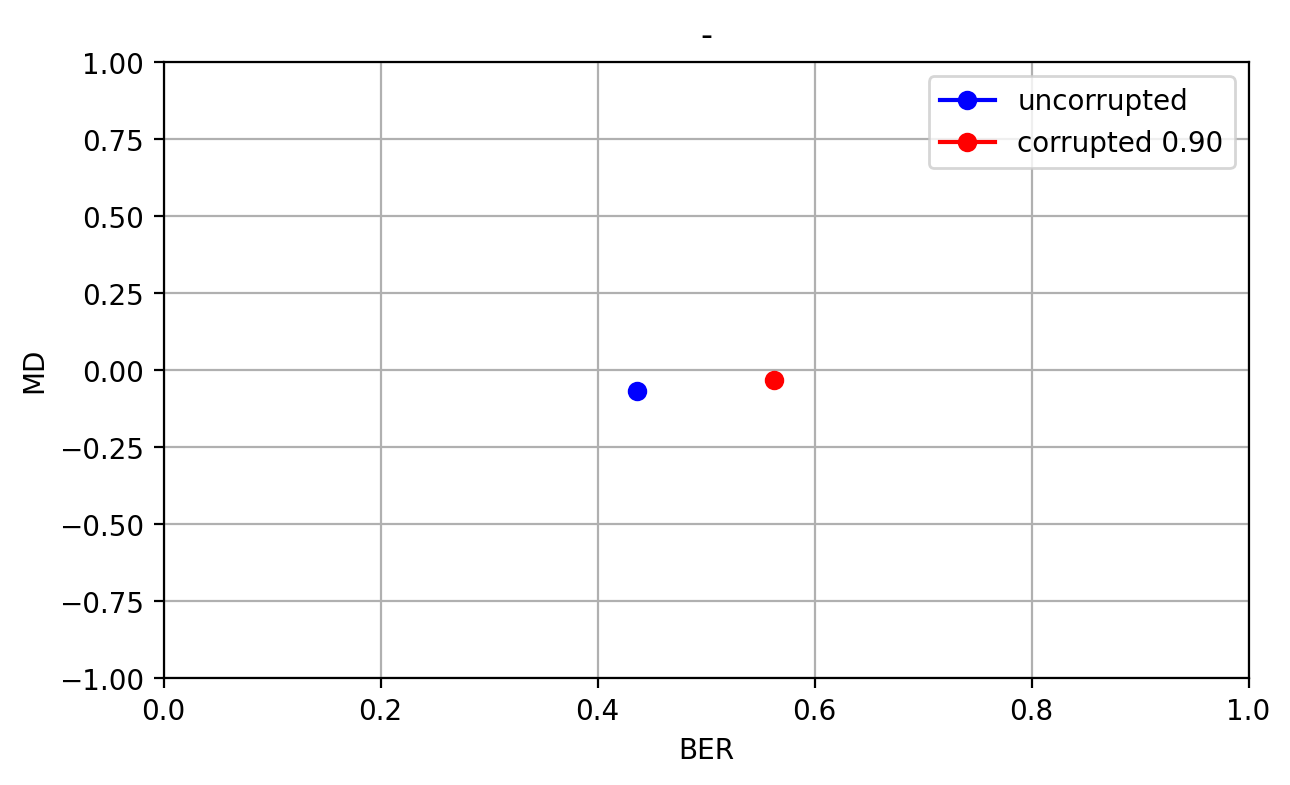

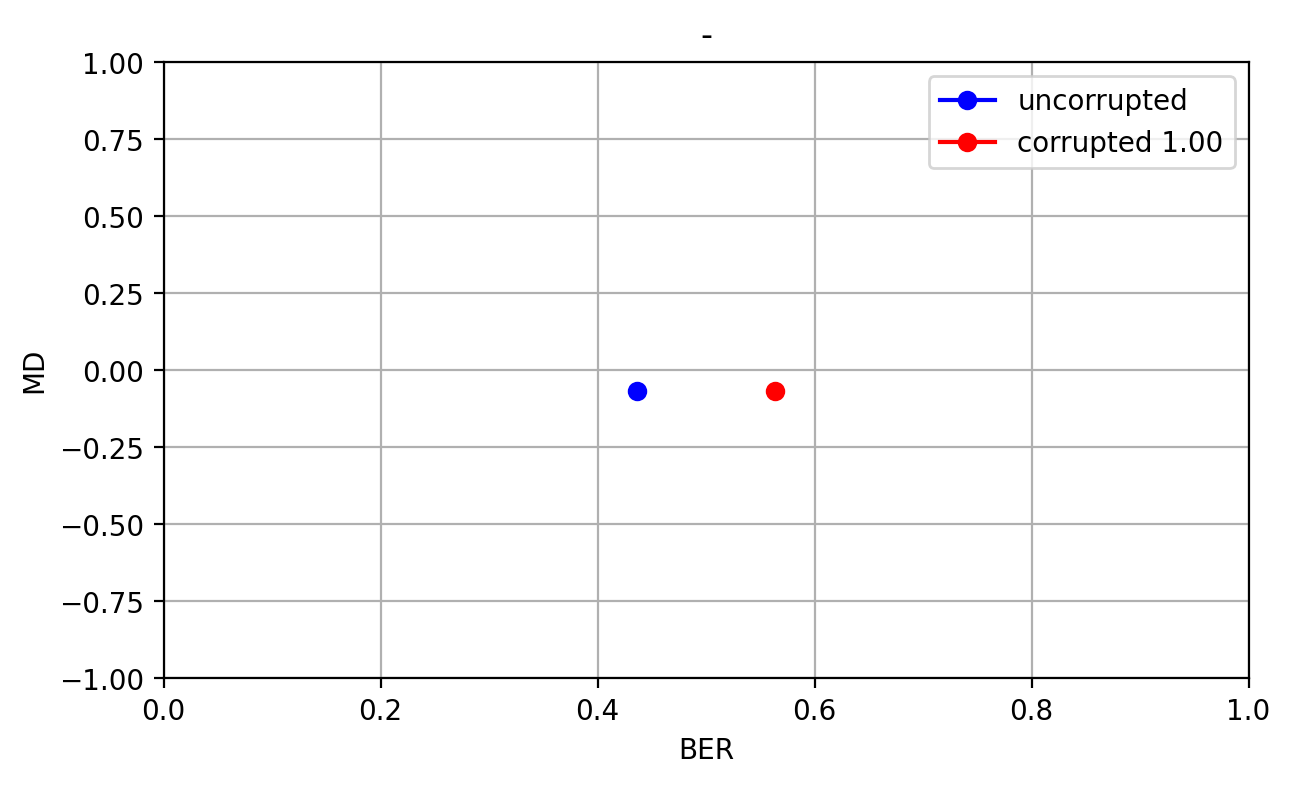

In [11]:
np.random.seed(0)  # Set seed for reproducibility
flip_prob = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]  # Probability of flipping each value   0, 0.1 0.2 ... 1
disc_factor = 0.5
lmd = 1.06

magnitude_list = []

for flip in flip_prob:
    X, Y, Y_sen = generate_synthetic_data(False, n_samples=2000, disc_factor=disc_factor)    #n_samples are per gaussian distributions, we have two hence total_n = 2*n_samples

    Y_corrupted = add_bin_noise(Y, flip)
    Y_sen_corrupted = add_bin_noise(Y_sen, flip)

    #Devide Set into training and test set
    split_index = int(0.7 * len(X))

    # Split the points into training and testing sets (80/20)
    X_train, X_test = X[:split_index], X[split_index:]
    Y_train, Y_test = Y[:split_index], Y[split_index:]
    Y_sen_train, Y_sen_test = Y_sen[:split_index], Y_sen[split_index:]
    Y_corr_train, Y_corr_test = Y_corrupted[:split_index], Y_corrupted[split_index:]
    Y_sen_corr_train, Y_sen_corr_test = Y_sen_corrupted[:split_index], Y_sen_corrupted[split_index:]


    p_reg, p_reg_cor, f_reg, f_reg_cor = LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression()
    p_reg.fit(X_train, Y_train)
    p_reg_cor.fit(X_train, Y_corr_train)
    f_reg.fit(X_train, Y_sen_train)
    f_reg_cor.fit(X_train, Y_sen_corr_train)


    
    BER_list = []
    MD_list = []
    DI_list = []

    BER_list_corr = []
    MD_list_corr = []
    DI_list_corr = []

    # Cost sensitivity of classes
    c, c_bar = 0.5, 0.5


    s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)
    # Apply step function H_a(z) with a = 0
    Y_pred = np.where(s > 0, 1, 0)


    BER = calc_BER(Y_pred, Y_test)
    MD = calc_MD(Y_pred, Y_sen_test, True)
    DI = calc_DI(Y_pred, Y_sen_test, True)
    BER_list.append(BER)
    MD_list.append(MD)
    DI_list.append(DI)

    s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)
    # Apply step function H_a(z) with a = 0
    Y_pred = np.where(s > 0, 1, 0)


    BER = calc_BER(Y_pred, Y_corr_test)
    MD = calc_MD(Y_pred, Y_sen_corr_test, False)
    DI = calc_DI(Y_pred, Y_sen_corr_test, False)

    BER_list_corr.append(BER)
    MD_list_corr.append(MD)
    DI_list_corr.append(DI)

    plt.figure(figsize=(7,4))
    plt.plot(BER_list[0], MD_list[0], marker='o', color='b', label='uncorrupted')
    plt.plot(BER_list_corr[0], MD_list_corr[0], marker='o', color='r', label=f'corrupted {flip:.2f}')


    # Add labels and title
    plt.xlabel("BER")
    plt.ylabel("MD")
    plt.title("-")
    plt.xlim(0,1)
    plt.ylim(-1,1)
    plt.legend()
    # Show grid
    plt.grid(True)
    #plt.show()
    plt.savefig(f"../img/E1_Label_Noise_for_Single_Points/Flipping_Probability_Effect_on_Corruption_lmd_{lmd:.4f}_flip_{flip:.4f}.png")

### Sanity Check - Dataset with only 1 point -> MD in (-1,0,1) and BER in (0,0.5,1)

In [5]:

# Initialize lists to store BER and MD for each lambda value
lmd= np.linspace(0, 2, 1)  # 100 values from 0 to 4

def calc_perf_fair(lmd, x, y, y_sen, y_corr, y_sen_corr):
    c, c_bar = 0.5, 0.5
    
    #predict point using f_reg and normal targets
    s = p_reg.predict_proba([x])[:, 1] - c - lmd * (f_reg.predict_proba([x])[:, 1] - c_bar)
    # Apply step function H_a(z) with a = 0
    y_pred = np.where(s > 0, 1, 0)
        
    BER = calc_BER(y_pred, y)
    MD = calc_MD(y_pred, y_sen, False)
    DI = calc_DI(y_pred, y_sen, False)

    #predict point using f_reg and corrupted targets
    s = p_reg.predict_proba([x])[:, 1] - c - lmd * (f_reg.predict_proba([x])[:, 1] - c_bar)
    # Apply step function H_a(z) with a = 0
    y_pred = np.where(s > 0, 1, 0)

    BER_corr = calc_BER(y_pred, y_corr)
    MD_corr = calc_MD(y_pred, y_sen_corr, False)
    DI_corr = calc_DI(y_pred, y_sen_corr, False)
    
    return BER, MD, DI, BER_corr, MD_corr, DI_corr
    
 

In [6]:
i=9
BER, MD, DI, BER_corr, MD_corr, DI_corr = calc_perf_fair(0, X_test[i], Y_test[i], Y_sen_test[i], Y_corr_test[i], Y_sen_corr_test[i])
print(BER,  BER_corr, MD, MD_corr, DI, DI_corr)
print()
print(print(X_test[i], Y_test[i], Y_corr_test[i], Y_sen_test[i], Y_sen_corr_test[i]))

0.0 0.5 -1.0 0.0 0.0 1.0

[4.00677533 7.43391068] 1.0 0.0 1.0 0.0
None


TypeError: unsupported format string passed to list.__format__

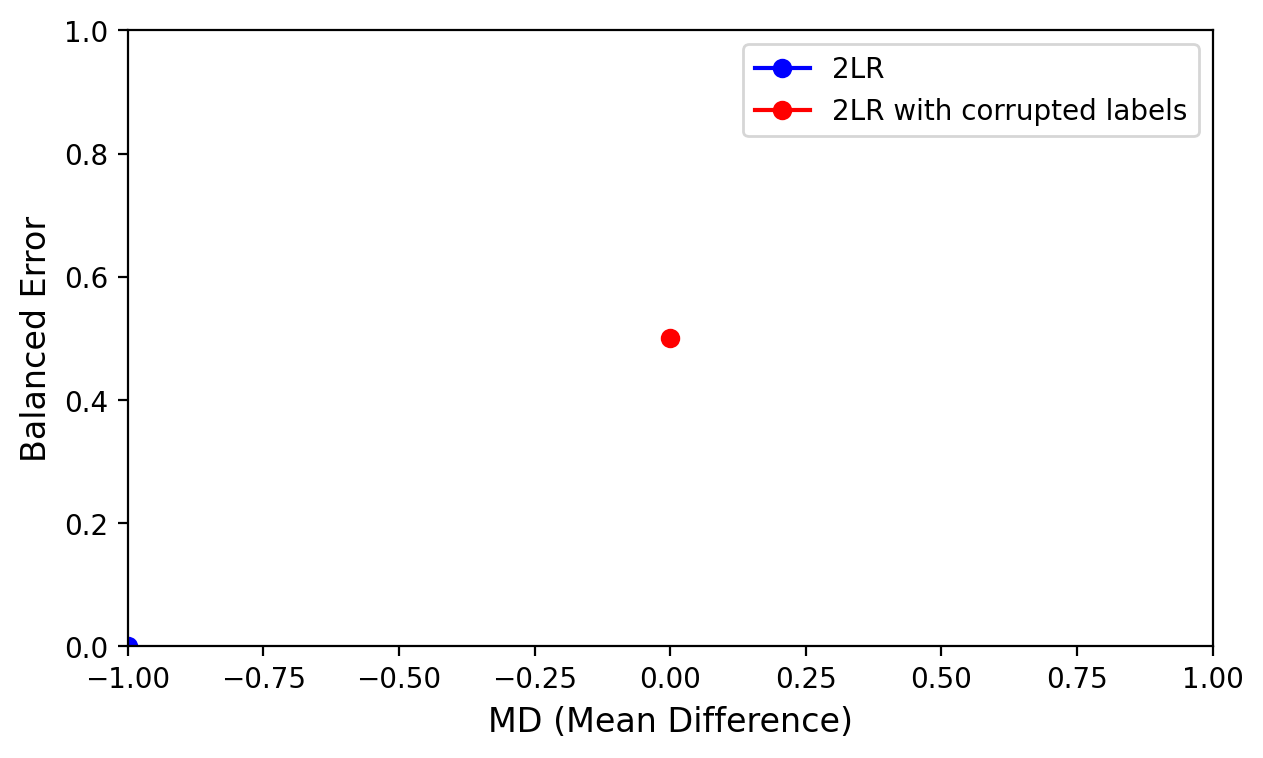

In [7]:
# Plot BER (y-axis) against MD (x-axis)
plt.figure(figsize=(7, 4))
# Plot BER vs MD
plt.plot(MD, BER, label="2LR", color="blue", marker='o')
plt.plot(MD_corr, BER_corr, label="2LR with corrupted labels", color="red", marker='o')

# Labels and Title
plt.xlabel("MD (Mean Difference)", fontsize=12)
plt.ylabel("Balanced Error", fontsize=12)

plt.xlim(-1, 1)
plt.ylim(0, 1)

plt.legend()
plt.savefig(f"../img/E1 - Label Noise/Label Noise MD {flip_prob:.2f} Flip Prob.png")
